In [1]:
import pandas as pd
import numpy as np
import os
import math
import gc
from PIL import Image
import cv2
import ast
import tensorflow as tf
import keras_cv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

2025-10-08 15:44:03.854992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759938244.058644      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759938244.112487      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("Available devices: \n")
for device in tf.config.list_logical_devices():
    print(device.name, device.device_type)

Available devices: 

/device:CPU:0 CPU
/device:GPU:0 GPU


I0000 00:00:1759938375.611725      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [3]:
def get_strategy():
    """
    Detects and returns the best TensorFlow distribution strategy.
    - TPUStrategy for TPU(s)
    - MirroredStrategy for GPU(s)
    - Default strategy for CPU
    """
    try:
        # Try TPU first
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print("Using TPU strategy:", type(strategy).__name__)
    except Exception:
        # If TPU not available, try GPU
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            strategy = tf.distribute.MirroredStrategy()
            print("Using GPU strategy:", type(strategy).__name__)
        else:
            # Fallback CPU
            strategy = tf.distribute.get_strategy()
            print("No TPU/GPU found. Using CPU strategy:", type(strategy).__name__)

    print("REPLICAS:", strategy.num_replicas_in_sync)
    return strategy

# Call it
strategy = get_strategy()

Using GPU strategy: MirroredStrategy
REPLICAS: 1


In [4]:
print("REPLICAS:", strategy.num_replicas_in_sync)
print("TensorFlow version:", tf.__version__)

REPLICAS: 1
TensorFlow version: 2.18.0


In [5]:
SEED = 28
def seed_everything(SEED):
    random.seed(SEED)
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    print('For reproducing purposes, everything seeded !')

seed_everything(SEED)

For reproducing purposes, everything seeded !


In [6]:
DATA_DIR = '/kaggle/input/global-wheat-detection'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')
CSV_PATH = os.path.join(DATA_DIR, 'train.csv')

In [17]:
num_train_images = len(os.listdir(TRAIN_DIR))
num_test_images = len(os.listdir(TEST_DIR))
print(f'Number of total images on Train directory: {num_train_images}')
print(f'Number of test images on Test directory: {num_test_images}')

Number of total images on Train directory: 3422
Number of test images on Test directory: 10


In [8]:
img_path = os.path.join(TRAIN_DIR, os.listdir(TRAIN_DIR)[0])
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
print(img.shape)

(1024, 1024, 3)


In [7]:
df = pd.read_csv(CSV_PATH)
df.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [10]:
df.shape

(147793, 5)

In [14]:
averaged_bbox_per_img = df.groupby('image_id').size().mean()
print(f'Average Bounding boxes exists in an image: {int(averaged_bbox_per_img)}')

Average Bounding boxes exists in an image: 43


In [15]:
bbox_counts = df.groupby('image_id').size()
print('Statistics of wheat head per image:')
print(bbox_counts.describe().T)

Statistics of wheat head per image:
count    3373.000000
mean       43.816484
std        20.374820
min         1.000000
25%        28.000000
50%        43.000000
75%        59.000000
max       116.000000
dtype: float64


In [ ]:
plt.figure(figsize= (12, 6))
sns.histplot(bbox_counts, bins= 30, kde= True, color= 'purple')
plt.title('Number of Bounding Boxes per Image')
plt.xlabel('Number of Bounding Boxes')
plt.ylabel('Number of images')

plt.show()

In [8]:
annonated_ids = set(df['image_id'].unique())
print(f'Number of images with Wheat: {len(annonated_ids)}')

Number of images with Wheat: 3373


In [9]:
all_images = [f.replace('.jpg', '') for f in os.listdir(TRAIN_DIR)]
empty_images = [f for f in all_images if f not in annonated_ids]
print(f'Number of images without annonation(Wheat): {len(empty_images)}')
print(f'Example of empty image: {empty_images[0]}')

Number of images without annonation(Wheat): 49
Example of empty image: dec23c826


In [19]:
empty_img_frac = len(empty_images) / len(os.listdir(TRAIN_DIR))
annonated_img_frac = len(annonated_ids) / len(os.listdir(TRAIN_DIR))

print(f'Empty images percentage: {empty_img_frac:.4f}')
print(f'Annonated images percentage: {annonated_img_frac:.4f}')
print("Empty images aren't dominated, no problem with them at all!")

Empty images percentage: 0.0143
Annonated images percentage: 0.9857
Empty images aren't dominated, no problem with them at all!


In [ ]:
img_path = os.path.join(TRAIN_DIR, empty_images[0] + '.jpg')
img = Image.open(img_path)

plt.imshow(img)
plt.axis('off')
plt.title(f'Example of empty: {empty_images[0]}.jpg')
plt.show()

In [21]:
def show_images(num_images= 6, cols= 3):
    files = os.listdir(TRAIN_DIR)[:num_images]
    rows = (num_images + cols - 1) // cols

    fig = plt.figure(figsize= (cols* 4, rows* 4))
    
    for i, fname in enumerate(files):
        img_path = os.path.join(TRAIN_DIR, fname)
        img = Image.open(img_path)
        img = img.resize((256, 256))

        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(fname)
        
    plt.tight_layout()
    plt.show()

In [ ]:
show_images(num_images= 6, cols= 3)

In [10]:
df['bbox'] = df['bbox'].apply(ast.literal_eval)
df['x_min'] = df['bbox'].apply(lambda b: b[0])
df['y_min'] = df['bbox'].apply(lambda b: b[1])
df['x_max'] = df['bbox'].apply(lambda b: b[0] + b[2])
df['y_max'] = df['bbox'].apply(lambda b: b[1] + b[3])

In [13]:
df.head()

image_id  width  height                         bbox   source  x_min  \
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1  834.0   
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1  226.0   
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1  377.0   
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1  834.0   
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1   26.0   

   y_min  x_max  y_max  
0  222.0  890.0  258.0  
1  548.0  356.0  606.0  
2  504.0  451.0  664.0  
3   95.0  943.0  202.0  
4  144.0  150.0  261.0

In [25]:
df['width'] = df['x_max'] - df['x_min']
df['height'] = df['y_max'] - df['y_min']
print(df[['width' ,'height']].describe().T)

           count       mean        std  min   25%   50%    75%    max
width   147793.0  84.435060  35.553450  1.0  62.0  78.0  100.0  987.0
height  147793.0  76.927306  33.853186  1.0  55.0  71.0   91.0  714.0


In [26]:
df.head()

image_id  width  height                         bbox   source  x_min  \
0  b6ab77fd7   56.0    36.0   [834.0, 222.0, 56.0, 36.0]  usask_1  834.0   
1  b6ab77fd7  130.0    58.0  [226.0, 548.0, 130.0, 58.0]  usask_1  226.0   
2  b6ab77fd7   74.0   160.0  [377.0, 504.0, 74.0, 160.0]  usask_1  377.0   
3  b6ab77fd7  109.0   107.0  [834.0, 95.0, 109.0, 107.0]  usask_1  834.0   
4  b6ab77fd7  124.0   117.0  [26.0, 144.0, 124.0, 117.0]  usask_1   26.0   

   y_min  x_max  y_max  
0  222.0  890.0  258.0  
1  548.0  356.0  606.0  
2  504.0  451.0  664.0  
3   95.0  943.0  202.0  
4  144.0  150.0  261.0

In [ ]:
fig, ax = plt.subplots(1, 2, figsize= (12, 6))
for i, col in enumerate(['width', 'height']):
    sns.histplot(df[col], bins= 50, kde= True, ax= ax[i])
    ax[i].set_title(f'Bounding Boxes {col} distribution')
    ax[i].set_xlim((0, 250))
    ax[i].set_xlabel(f'{col} pixels')
    ax[i].set_ylabel('Count')

In [29]:
def show_images_with_bboxes(df, image_dir, nrows, ncols):
    # Pick random images from the train dir
    files = os.listdir(image_dir)
    selected_files = random.sample(files, nrows * ncols)

    fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))

    for ax, fname in zip(axs.flatten(), selected_files):
        image_id = fname.replace('.jpg', '')

        # Load image
        img_path = os.path.join(image_dir, fname)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Get bboxes if exists
        if image_id in df['image_id'].values:
            bboxes = df[df['image_id'] == image_id][['x_min', 'y_min', 'x_max', 'y_max']].values
            for (x_min, y_min, x_max, y_max) in bboxes:
                start_point = (int(x_min), int(y_min))
                end_point = (int(x_max), int(y_max))
                color = (255, 0, 0)
                thickness = 2
                cv2.rectangle(img, start_point, end_point, color, thickness)

        # Show image
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(fname, fontsize=8)

    plt.tight_layout()
    plt.show()

In [ ]:
show_images_with_bboxes(df, TRAIN_DIR, 2, 2)

In [11]:
grouped = df.groupby('image_id')[['x_min', 'y_min', 'x_max', 'y_max']].apply(
    lambda x: x.values.tolist()
)

In [12]:
data_dicts = []
for image_id, bboxes in grouped.items():
    img_path = os.path.join(TRAIN_DIR, f'{image_id}.jpg')
    bboxes = np.array(bboxes, dtype=np.float32).reshape(-1, 4)
    data_dicts .append({
        'image_path': img_path,
         'bboxes': bboxes
    })

print(data_dicts[:2])

[{'image_path': '/kaggle/input/global-wheat-detection/train/00333207f.jpg', 'bboxes': array([[   0.,  654.,   37.,  765.],
       [   0.,  817.,  135.,  915.],
       [   0.,  192.,   22.,  273.],
       [   4.,  342.,   67.,  380.],
       [  82.,  334.,  164.,  415.],
       [  30.,  296.,   78.,  345.],
       [ 176.,  316.,  246.,  370.],
       [ 176.,  126.,  245.,  177.],
       [ 203.,   38.,  245.,  123.],
       [   3.,  142.,   92.,  200.],
       [ 236.,    0.,  296.,   25.],
       [ 329.,    0.,  404.,   57.],
       [ 796.,    0.,  865.,   96.],
       [ 659.,   24.,  718.,  114.],
       [ 540.,   81.,  680.,  161.],
       [ 233.,  152.,  322.,  203.],
       [ 422.,  159.,  480.,  209.],
       [ 462.,  153.,  667.,  217.],
       [ 468.,  210.,  576.,  263.],
       [ 417.,  235.,  553.,  323.],
       [ 287.,  257.,  343.,  308.],
       [ 283.,  322.,  400.,  398.],
       [ 393.,  329.,  567.,  429.],
       [ 606.,  346.,  653.,  403.],
       [ 611.,  286.,  681

In [13]:
train_dicts, val_dicts = train_test_split(
    data_dicts,
    test_size= 0.2,
    random_state= SEED,
    shuffle= True
)
print('Train and Validation dicts created successfully! 20% of data stored for validation')

Train and Validation dicts created successfully! 20% of data stored for validation


In [14]:
for fname in empty_images:
    img_path = os.path.join(TRAIN_DIR, f'{fname}.jpg')
    bboxes = np.zeros((0, 4), dtype=np.float32)
    train_dicts.append({
        'image_path': img_path,
        'bboxes': bboxes
    })

random.shuffle(train_dicts)

In [15]:
IMG_SIZE = (1024, 1024)
NUM_CLASSES = 1
GLOBAL_CLIPNORM = 10.0
LEARNING_RATE = 1e-3
INITIAL_EPOCH = 20
FINAL_EPOCH = INITIAL_EPOCH + 50
MAX_BOXES = 120
AUTO = tf.data.AUTOTUNE
BATCH_SIZE_PER_REPLICA = 4
BUFFER_SHUFFLE_SIZE = 512
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
print(f'Global Batch size: {BATCH_SIZE}')

Global Batch size: 4


In [16]:
# This generator will read one image and its boxes at a time
def data_generator(dict_list):
    for sample in dict_list:
        image = tf.io.read_file(sample['image_path'])
        image = tf.image.decode_jpeg(image, channels=3)
        
        # We need to provide the classes alongside the boxes
        num_boxes = sample['bboxes'].shape[0]
        bounding_boxes = {
            'boxes': sample['bboxes'],
            'classes': tf.zeros(shape=(num_boxes,), dtype=tf.float32)
        }
        yield {'images': image, 'bounding_boxes': bounding_boxes}

In [17]:
mosaic = keras_cv.layers.Mosaic(bounding_box_format="xyxy", name= 'mosaic')
random_crop = keras_cv.layers.RandomCrop(
    height= 640,
    width= 640,
    bounding_box_format= 'xyxy'
)
random_flip = keras_cv.layers.RandomFlip(
    mode="horizontal", 
    bounding_box_format="xyxy"
)
# Use a gentler scaling factor to avoid making small wheat heads disappear
train_resizing = keras_cv.layers.JitteredResize(
    target_size=IMG_SIZE, 
    scale_factor=(0.9, 1.1), 
    bounding_box_format="xyxy"
)
# The validation augmenter should only resize, not apply random augmentations
val_resizing = keras_cv.layers.JitteredResize(
    target_size=IMG_SIZE, 
    scale_factor=(1.0, 1.0), 
    bounding_box_format="xyxy"
)

random_color_jitter = keras_cv.layers.RandomColorJitter(
    value_range= (0, 255),
    brightness_factor= 0.2,
    contrast_factor= 0.2,
    saturation_factor= 0.2,
    hue_factor= 0.1
)

random_color_deg = keras_cv.layers.RandomColorDegeneration(
    factor= (0.2, 0.7),
    seed= SEED
)


In [18]:
def dict_to_tuple(inputs):
    return inputs['images'], inputs['bounding_boxes']

In [19]:
def create_dataset(dict_list, batch_size=BATCH_SIZE, shuffle=True, is_training=True):
    
    output_signature = {
        'images': tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
        'bounding_boxes': {
            'boxes': tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
            'classes': tf.TensorSpec(shape=(None,), dtype=tf.float32)
        }
    }
    
    ds = tf.data.Dataset.from_generator(
        lambda: data_generator(dict_list),
        output_signature=output_signature
    )

    if shuffle:
        ds = ds.shuffle(BUFFER_SHUFFLE_SIZE)

    ds = ds.padded_batch(
        batch_size=batch_size,
        padding_values={
            'images': tf.constant(0, dtype=tf.uint8),
            'bounding_boxes': {
                'boxes': tf.constant(-1, dtype=tf.float32),
                'classes': tf.constant(-1, dtype=tf.float32)
            }
        },
        drop_remainder=True
    )
    
    # --- START OF AUGMENTATION LOGIC ---
    
    # FIX: Apply resizing first to ensure a static image shape (e.g., 1024x1024)
    # This is CRITICAL for KerasCV augmentations like Mosaic when applied
    # to a batched dataset.
    
    if is_training:
        ds = ds.map(train_resizing, num_parallel_calls=AUTO)
        # Apply Mosaic next to the batched dataset with a static shape
        ds = ds.map(mosaic, num_parallel_calls=AUTO)
        ds = ds.map(random_flip, num_parallel_calls=AUTO)
        ds = ds.map(random_color_jitter, num_parallel_calls= AUTO)
        ds = ds.map(random_color_deg, num_parallel_calls= AUTO)
    else:
        ds = ds.map(val_resizing, num_parallel_calls=AUTO)
    
    # --- END OF AUGMENTATION LOGIC ---

    ds = ds.map(dict_to_tuple, num_parallel_calls=AUTO)
    
    return ds.prefetch(AUTO)

In [20]:
# --- Find this existing code in your notebook ---
train_dataset = create_dataset(train_dicts, shuffle=True, is_training=True)
val_dataset = create_dataset(val_dicts, shuffle=False, is_training=False)


print('✅ Train and Validation datasets are ready!')

✅ Train and Validation datasets are ready!


In [32]:
for images, bounding_boxes in train_dataset.take(1):
    bboxes = bounding_boxes["boxes"]
    classes = bounding_boxes["classes"]

    print("Images shape:", images.shape)
    print("Boxes shape:", bboxes.shape)
    print("Classes shape:", classes.shape)

W0000 00:00:1759917758.823123      36 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 2048 } dim { size: 2048 } dim { size: 3 } } } inputs { dtype: DT_FLOAT shape { dim { size: -7 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -7 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 1024 } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: -7 } dim { 

Images shape: (4, 1024, 1024, 3)
Boxes shape: (4, None, 4)
Classes shape: (4, None)


In [21]:
NUM_TRAIN_IMAGES = len(train_dicts)
NUM_VAL_IMAGES   = len(val_dicts)

steps_per_epoch  = math.ceil(NUM_TRAIN_IMAGES / BATCH_SIZE)
validation_steps = math.ceil(NUM_VAL_IMAGES / BATCH_SIZE)

print(f"Steps per Epoch: {steps_per_epoch}")
print(f"Validation Steps: {validation_steps}")

Steps per Epoch: 687
Validation Steps: 169


In [ ]:
# After creating your datasets...
del train_dicts, val_dicts, data_dicts, annonated_ids, all_images, empty_images
import gc
gc.collect() # Force garbage collection

W0000 00:00:1759666681.062024      36 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 2048 } dim { size: 2048 } dim { size: 3 } } } inputs { dtype: DT_FLOAT shape { dim { size: -7 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -7 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 1024 } } device { type: "CPU" vendor: "GenuineIntel" model: "111" frequency: 2199 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 57671680 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: -7 } dim { s

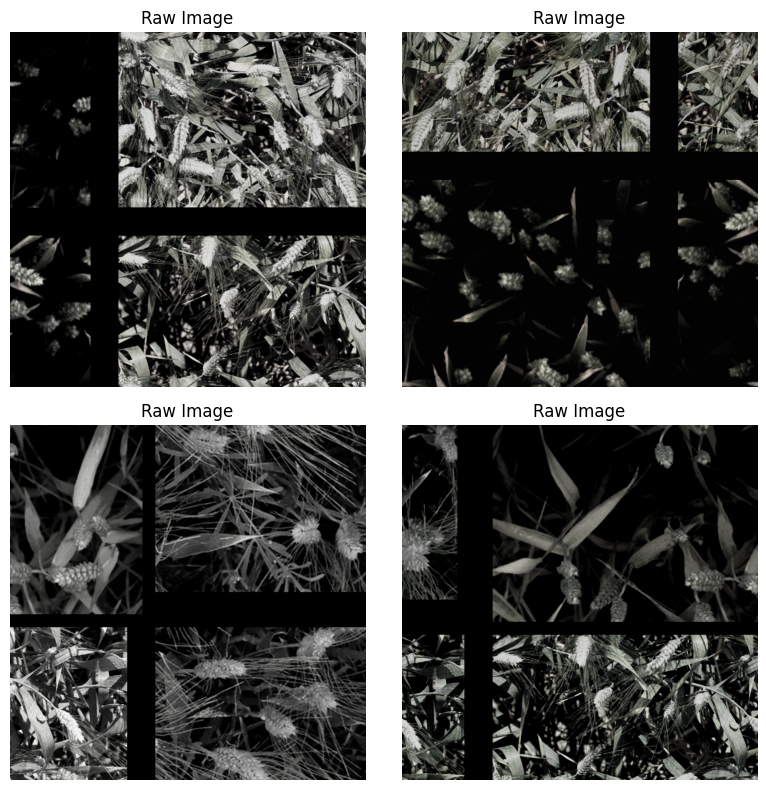

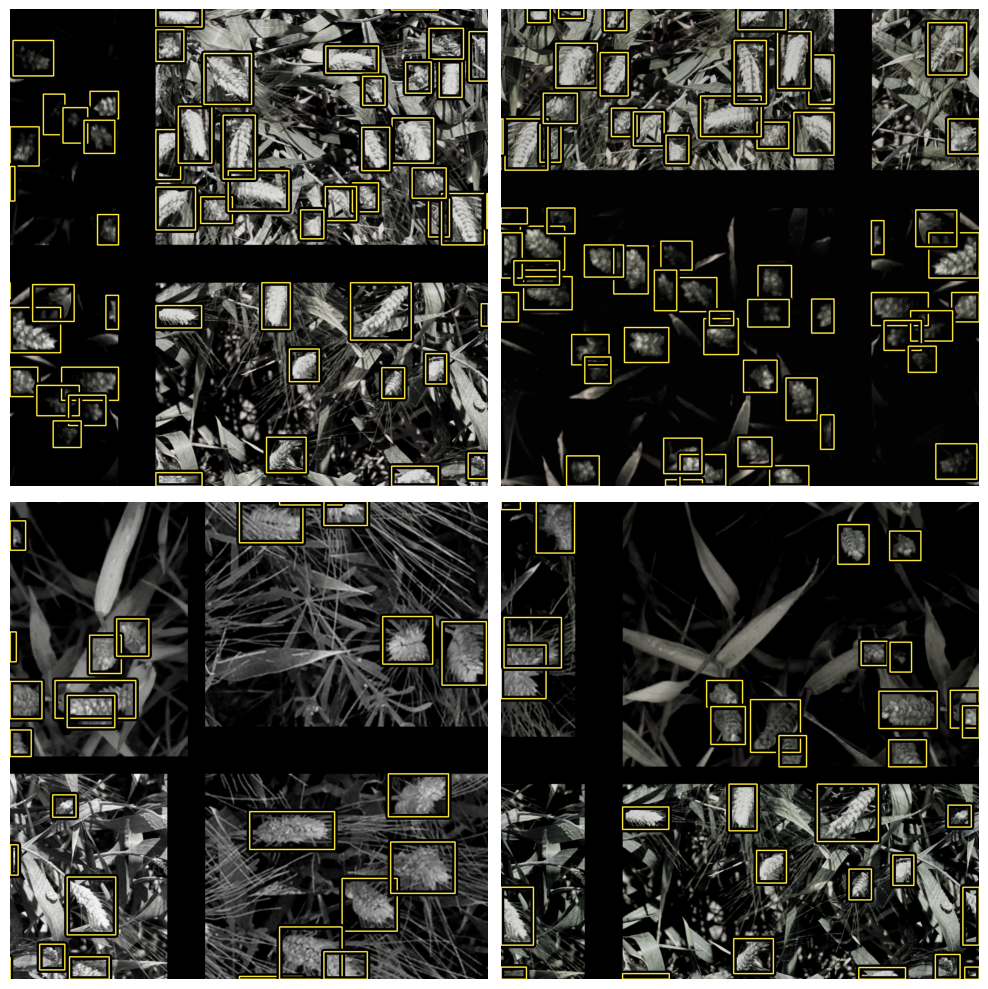

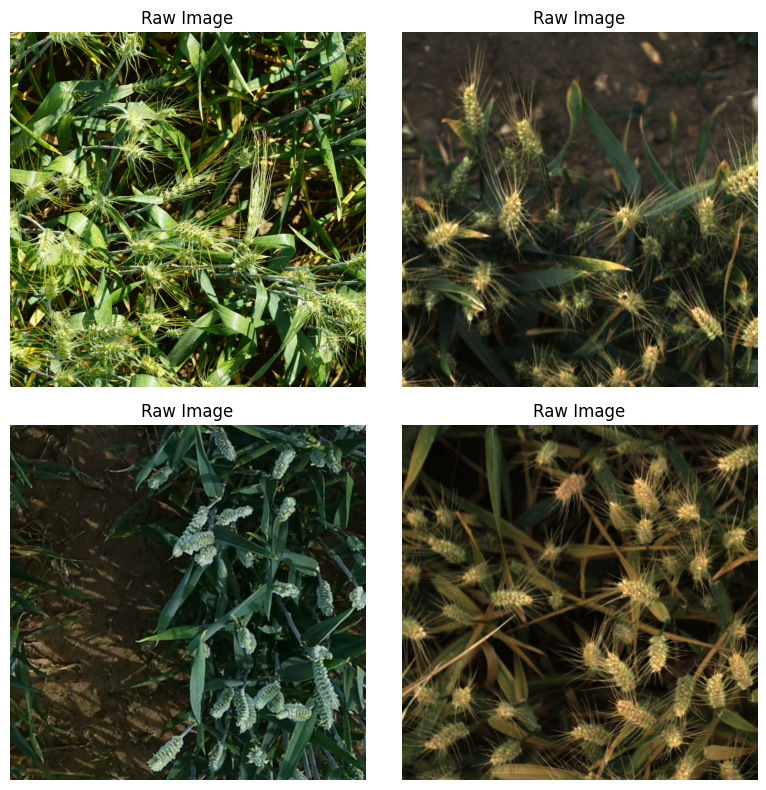

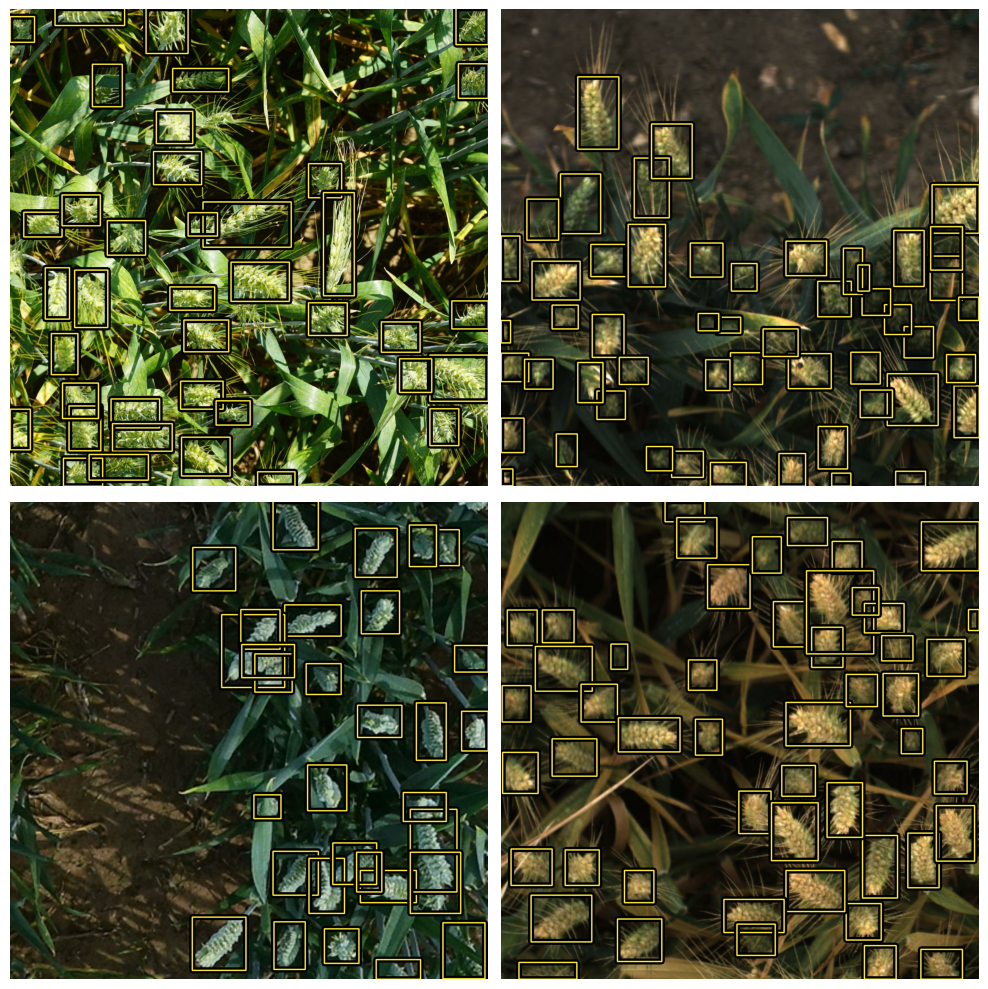

In [37]:
def visualize_dataset(dataset, rows=2, cols=2, value_range=(0, 255), bounding_box_format="xyxy"):
    # Take a single batch
    batch = next(iter(dataset.take(1)))
    images, bounding_boxes = batch# our dataset is already (images, bounding_boxes)
    
    num_images = rows * cols

    fig, axs = plt.subplots(rows, cols, figsize= (4* cols, 4* rows))
    axs = axs.flatten()
    for i in range(num_images):
        img = images[i].numpy().astype('uint8')

        axs[i].imshow(img)
        axs[i].set_title('Raw Image')
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()
         
    # Plot bounding box gallery
    keras_cv.visualization.plot_bounding_box_gallery(
        images,                 # images
        y_pred= bounding_boxes,            # y_true
        value_range=value_range,    # range of image values
        rows=rows,
        cols=cols,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
    )

    plt.tight_layout()
    plt.show()

# Usage
visualize_dataset(train_dataset, rows=2, cols=2)
visualize_dataset(val_dataset, rows=2, cols=2)

In [34]:
def create_model():
    backbone = keras_cv.models.YOLOV8Backbone.from_preset(
        'yolo_v8_m_backbone_coco',
        name= 'yolov8_backbone'
    )

    model = keras_cv.models.YOLOV8Detector(
        num_classes= NUM_CLASSES,
        bounding_box_format= 'xyxy',
        fpn_depth= 3,
        backbone= backbone,
        name= 'yolov8_detector'
    )
    model.summary()
    return model

In [35]:
with strategy.scope():
    
    model = create_model()
    for layer in model.backbone.layers:
        layer.trainable = False

    # Freeze BN stats explicitly
    for layer in model.backbone.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False

    
    optimizer = tf.keras.optimizers.Adam(
    learning_rate= LEARNING_RATE,
    global_clipnorm= GLOBAL_CLIPNORM)

    classification_loss = keras_cv.losses.FocalLoss()
    model.compile(
        optimizer= optimizer,
        classification_loss= classification_loss,
        box_loss= 'ciou',
        steps_per_execution= 32 if isinstance(strategy, tf.distribute.TPUStrategy) else 1
    )

Model: "yolov8_detector"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, None,     │ 11,872,464 │ input_layer_1[0]… │
│ (Functional)        │ None, 192),       │            │                   │
│                     │ (None, None,      │            │                   │
│                     │ None, 384),       │            │                   │
│                     │ (None, None,      │            │                   │
│                     │ None, 576)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat (Repeat)     │ (None, None,      │          0 │ functional[0][2]  │
│                     │ None, 576)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_1 (Repeat)   │ (None, None,      │          0 │ repeat[0][0]      │
│                     │ None, 576)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, None,      │          0 │ repeat_1[0][0],   │
│ (Concatenate)       │ None, 960)        │            │ functional[0][1]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_co… │ (None, None,      │    368,640 │ concatenate_5[0]… │
│ (Conv2D)            │ None, 384)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_bn  │ (None, None,      │      1,536 │ pa_fpn_p4p5_pre_… │
│ (BatchNormalizatio… │ None, 384)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre     │ (None, None,      │          0 │ pa_fpn_p4p5_pre_… │
│ (Activation)        │ None, 384)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ split_4 (Split)     │ [(None, None,     │          0 │ pa_fpn_p4p5_pre[… │
│                     │ None, 192),       │            │                   │
│                     │ (None, None,      │            │                   │
│                     │ None, 192)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_0_… │ (None, None,      │          0 │ split_4[0][1]     │
│ (ZeroPadding2D)     │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_0_… │ (None, None,      │    331,776 │ pa_fpn_p4p5_pre_… │
│ (Conv2D)            │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_0_… │ (None, None,      │        768 │ pa_fpn_p4p5_pre_… │
│ (BatchNormalizatio… │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_0_1 │ (None, None,      │          0 │ pa_fpn_p4p5_pre_… │
│ (Activation)        │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_0_… │ (None, None,      │          0 │ pa_fpn_p4p5_pre_… │
│ (ZeroPadding2D)     │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_0_… │ (None, None,      │    331,776 │ pa_fpn_p4p5_pre_

 Total params: 26,813,907 (102.29 MB)

 Trainable params: 26,779,635 (102.16 MB)

 Non-trainable params: 34,272 (133.88 KB)

In [30]:
# Take one batch
example_batch = next(iter(train_dataset.take(1)))
images, bounding_boxes = example_batch  # unpack tuple

# Evaluate
try:
    model.evaluate(train_dataset.take(1), verbose=True)
except Exception as e:
    print("Your model is not compatible with the dataset you defined earlier.")
    print("Error:", e)
else:
    # Predict using the images dict
    predictions = model.predict(images, verbose=True)


W0000 00:00:1759172899.674751      36 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 2048 } dim { size: 2048 } dim { size: 3 } } } inputs { dtype: DT_FLOAT shape { dim { size: -7 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -7 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 1024 } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: -7 } dim { 

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - box_loss: 3.1766 - class_loss: 51.6817 - loss: 54.8583


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [22]:
class EvaluateCOCOMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,  # We will control evaluation timing manually
        )
        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.metrics.reset_state()

        # ---- START: MODIFIED SECTION ----
        # 1. Create lists to hold all ground truth and prediction data
        y_true_list = []
        y_pred_list = []

        # 2. Iterate through the entire validation dataset to collect data
        for images, y_true in self.data:
            y_pred = self.model.predict(images, verbose=0)
            y_true_list.append(y_true)
            y_pred_list.append(y_pred)

        # 3. Concatenate all batches into single, large ragged tensors
        y_true_concat = {
            'boxes': tf.concat([item['boxes'] for item in y_true_list], axis=0),
            'classes': tf.concat([item['classes'] for item in y_true_list], axis=0)
        }
        # Note: model prediction includes 'confidence', which we also need to concatenate
        y_pred_concat = {
            'boxes': tf.concat([item['boxes'] for item in y_pred_list], axis=0),
            'classes': tf.concat([item['classes'] for item in y_pred_list], axis=0),
            'confidence': tf.concat([item['confidence'] for item in y_pred_list], axis=0)
        }
        # ---- END: MODIFIED SECTION ----

        # 4. Update the metric's state ONCE with the full dataset
        self.metrics.update_state(y_true_concat, y_pred_concat)

        # 5. Get the final results
        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        
        # Manually print the validation metrics
        print(f"\nEpoch {epoch+1}: Validation Metrics")
        for key, value in metrics.items():
            print(f"  {key}: {value:.4f}")
            
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)
            print(f"✅ Validation MaP improved to {current_map:.4f}. Model saved to {self.save_path}")

        return logs

In [37]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

coco_cb = EvaluateCOCOMetricsCallback(val_dataset, 
                                       "/kaggle/working/initial_model.keras")
early_stopping_cb = EarlyStopping(
    monitor= 'MaP',
    patience= 5,
    restore_best_weights= True,
    mode= 'max'
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor= 'MaP',
    patience= 4,
    factor= 0.5,
    min_lr= LEARNING_RATE * 1e-3,
    verbose= 1
)

tb_cb = TensorBoard(
    log_dir= '/kaggle/working/logs',
    histogram_freq= 1
)

callbacks = [
    coco_cb,
    early_stopping_cb,
    reduce_lr_cb,
    tb_cb
]

In [38]:
# Set the number of epochs for this training phase
print("--- Starting Phase 1: Warmup Training ---")
# Fit the model to the training data
history = model.fit(train_dataset.repeat(), 
                    validation_data= val_dataset.repeat(),
                    epochs= INITIAL_EPOCH,
                    callbacks= [callbacks],
                    steps_per_epoch= steps_per_epoch,
                    validation_steps= validation_steps)

--- Starting Phase 1: Warmup Training ---


W0000 00:00:1759917920.720270      36 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 2048 } dim { size: 2048 } dim { size: 3 } } } inputs { dtype: DT_FLOAT shape { dim { size: -7 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -7 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 1024 } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: -7 } dim { 

Epoch 1/20


W0000 00:00:1759917941.241752      36 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 2048 } dim { size: 2048 } dim { size: 3 } } } inputs { dtype: DT_FLOAT shape { dim { size: -7 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -7 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 1024 } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: -7 } dim { 

687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - box_loss: 1.9787 - class_loss: 1.7839e-05 - loss: 1.9787

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_3']
Received: inputs=Tensor(shape=(4, 1024, 1024, 3))
  warnings.warn(msg)



Epoch 1: Validation Metrics
  MaP: 0.2962
  MaP@[IoU=50]: 0.6640
  MaP@[IoU=75]: 0.2150
  MaP@[area=small]: 0.0225
  MaP@[area=medium]: 0.3236
  MaP@[area=large]: 0.2280
  Recall@[max_detections=1]: 0.0118
  Recall@[max_detections=10]: 0.1055
  Recall@[max_detections=100]: 0.4429
  Recall@[area=small]: 0.0318
  Recall@[area=medium]: 0.4686
  Recall@[area=large]: 0.3568
✅ Validation MaP improved to 0.2962. Model saved to /kaggle/working/initial_model.keras
687/687 ━━━━━━━━━━━━━━━━━━━━ 985s 1s/step - box_loss: 1.9783 - class_loss: 1.7823e-05 - loss: 1.9783 - val_box_loss: 1.3958 - val_class_loss: 3.3367e-06 - val_loss: 1.3958 - MaP: 0.2962 - MaP@[IoU=50]: 0.6640 - MaP@[IoU=75]: 0.2150 - MaP@[area=small]: 0.0225 - MaP@[area=medium]: 0.3236 - MaP@[area=large]: 0.2280 - Recall@[max_detections=1]: 0.0118 - Recall@[max_detections=10]: 0.1055 - Recall@[max_detections=100]: 0.4429 - Recall@[area=small]: 0.0318 - Recall@[area=medium]: 0.4686 - Recall@[area=large]: 0.3568 - learning_rate: 0.0010

In [27]:
with strategy.scope():
    model = tf.keras.models.load_model('/kaggle/input/wheat-detection/keras/default/1/initial_model.keras',
            custom_objects = {
                'YOLOV8Detector': keras_cv.models.YOLOV8Detector,
                'YOLOV8Backbone': keras_cv.models.YOLOV8Backbone
            }
    )

model.backbone.trainable = True

with strategy.scope():
    optimizer = tf.keras.optimizers.Adam(
        learning_rate = LEARNING_RATE * 0.1,
        global_clipnorm = GLOBAL_CLIPNORM
    )

    model.compile(
        optimizer = optimizer,
        classification_loss = keras_cv.losses.FocalLoss(),
        box_loss = 'ciou',
        steps_per_execution= 32 if isinstance(strategy, tf.distribute.TPUStrategy) else 1
    )

In [ ]:
with strategy.scope():
    model = tf.keras.models.load_model('/kaggle/working/initial_model_wheat_detection.keras',
            custom_objects = {
                'YOLOV8Detector': keras_cv.models.YOLOV8Detector,
                'YOLOV8Backbone': keras_cv.models.YOLOV8Backbone
            }
    )

model.backbone.trainable = True

with strategy.scope():
    optimizer = tf.keras.optimizers.Adam(
        learning_rate = LEARNING_RATE * 0.1,
        global_clipnorm = GLOBAL_CLIPNORM
    )

    model.compile(
        optimizer = optimizer,
        classification_loss = keras_cv.losses.FocalLoss(),
        box_loss = 'ciou',
        steps_per_execution= 32 if isinstance(strategy, tf.distribute.TPUStrategy) else 1
    )

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

coco_cb = EvaluateCOCOMetricsCallback(val_dataset, 
                                       "/kaggle/working/final_wheat_detection1.keras")
early_stopping_cb = EarlyStopping(
    monitor= 'MaP',
    patience= 5,
    restore_best_weights= True,
    mode= 'max'
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor= 'MaP',
    patience= 4,
    factor= 0.5,
    min_lr= LEARNING_RATE * 1e-4,
    verbose= 1
)

tb_cb = TensorBoard(
    log_dir= '/kaggle/working/logs',
    histogram_freq= 1
)

callbacks = [
    coco_cb,
    early_stopping_cb,
    reduce_lr_cb,
    tb_cb
]

In [ ]:
print("--- Starting Phase 2.1: Fine-Tune Training ---")
final_history = model.fit(
    train_dataset.repeat(),
    epochs= FINAL_EPOCH,
    initial_epoch= INITIAL_EPOCH,
    validation_data= val_dataset.repeat(),
    steps_per_epoch= steps_per_epoch,
    validation_steps= validation_steps,
    callbacks= callbacks
)

--- Starting Phase 2.1: Fine-Tune Training ---


W0000 00:00:1759938650.858065      36 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 2048 } dim { size: 2048 } dim { size: 3 } } } inputs { dtype: DT_FLOAT shape { dim { size: -7 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -7 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 1024 } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: -7 } dim { 

Epoch 21/70


W0000 00:00:1759938677.105489      36 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 2048 } dim { size: 2048 } dim { size: 3 } } } inputs { dtype: DT_FLOAT shape { dim { size: -7 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -7 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 1024 } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: -7 } dim { 

687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - box_loss: 1.2497 - class_loss: 3.0752e-06 - loss: 1.2497

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_765']
Received: inputs=Tensor(shape=(4, 1024, 1024, 3))
  warnings.warn(msg)



Epoch 21: Validation Metrics
  MaP: 0.4253
  MaP@[IoU=50]: 0.7687
  MaP@[IoU=75]: 0.4234
  MaP@[area=small]: 0.0609
  MaP@[area=medium]: 0.4233
  MaP@[area=large]: 0.4560
  Recall@[max_detections=1]: 0.0146
  Recall@[max_detections=10]: 0.1377
  Recall@[max_detections=100]: 0.5295
  Recall@[area=small]: 0.1376
  Recall@[area=medium]: 0.5232
  Recall@[area=large]: 0.5716
✅ Validation MaP improved to 0.4253. Model saved to /kaggle/working/final_wheat_detection1.keras
687/687 ━━━━━━━━━━━━━━━━━━━━ 1111s 2s/step - box_loss: 1.2496 - class_loss: 3.0752e-06 - loss: 1.2496 - val_box_loss: 1.2254 - val_class_loss: 3.0147e-06 - val_loss: 1.2254 - MaP: 0.4253 - MaP@[IoU=50]: 0.7687 - MaP@[IoU=75]: 0.4234 - MaP@[area=small]: 0.0609 - MaP@[area=medium]: 0.4233 - MaP@[area=large]: 0.4560 - Recall@[max_detections=1]: 0.0146 - Recall@[max_detections=10]: 0.1377 - Recall@[max_detections=100]: 0.5295 - Recall@[area=small]: 0.1376 - Recall@[area=medium]: 0.5232 - Recall@[area=large]: 0.5716 - learning_r

In [ ]:
yolo_model = tf.keras.models.load_model('/kaggle/working/final_wheat_detection1.keras',
            custom_objects = {
                'YOLOV8Detector': keras_cv.models.YOLOV8Detector,
                'YOLOV8Backbone': keras_cv.models.YOLOV8Backbone
            }
    )

In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)

    # y_pred is already in dict format (boxes, classes, confidence)
    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,   # no need for to_ragged
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
    )
visualize_detections(yolo_model, val_dataset, bounding_box_format= 'xyxy')

In [80]:
def load_and_preprocess(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img

In [92]:
example_batch = next(iter(train_dataset.take(1)))
img, bb = example_batch
# Run with model.predict(), not just model()
preds = yolo_model.predict(img)

print(preds)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_698']
Received: inputs=Tensor(shape=(4, 640, 640, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
{'boxes': array([[[ 1.7019820e+02,  2.8240433e+00,  2.6920218e+02,  1.1330667e+02],
        [ 4.3338837e+02,  1.2551322e+02,  5.3579602e+02,  2.2101505e+02],
        [ 2.9594955e+02,  1.6952190e+02,  3.9629028e+02,  2.7200638e+02],
        ...,
        [-1.0000000e+00, -1.0000000e+00, -1.0000000e+00, -1.0000000e+00],
        [-1.0000000e+00, -1.0000000e+00, -1.0000000e+00, -1.0000000e+00],
        [-1.0000000e+00, -1.0000000e+00, -1.0000000e+00, -1.0000000e+00]],

       [[ 2.2637772e+01,  6.3054905e+01,  1.5598872e+02,  1.5225044e+02],
        [-2.2537041e-01,  3.9612598e+02,  8.7999207e+01,  5.0620560e+02],
        [ 4.5030975e-01,  5.4016647e+00,  1.0500228e+02,  1.0275450e+02],
        ...,
        [-1.0000000e+00, -1.0000000e+00, -1.0000000e+00, -1.0000000e+00],
        [-1.0000000e+00, -1.0000000e+00, -1.0000000e+00, -1.0000000e+00],
        [-1.0000000e+00, -1.0000000e+00, -1.0000000e+00, -1.0000000e+00]],

       [[ 1.9629224e+02,  3.2364262e

In [ ]:
def preprocess_for_inference(image_path):
    """Loads and resizes a single image for model prediction."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    return image

In [ ]:
test_image_paths = [os.path.join(TEST_DIR, fname) for fname in os.listdir(TEST_DIR)]

# Create a dataset from the file paths
test_ds = tf.data.Dataset.from_tensor_slices(test_image_paths)

# Map the preprocessing function
test_ds = test_ds.map(preprocess_for_inference, num_parallel_calls=tf.data.AUTOTUNE)

# Batch the dataset
BATCH_SIZE = 4 # You can adjust this based on your RAM
test_ds = test_ds.batch(BATCH_SIZE)

# Run prediction on the entire test set
y_preds = yolo_model.predict(test_ds)

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(image_paths, predictions, count=4, confidence_threshold=0.5):
    """Visualizes model predictions on a set of images."""
    num_images_to_show = min(count, len(image_paths))
    
    # Load the original images for display
    images_to_plot = [np.array(Image.open(p)) for p in image_paths[:num_images_to_show]]
    
    # Extract predictions for the images we'll show
    boxes = predictions['boxes'][:num_images_to_show]
    confidences = predictions['confidence'][:num_images_to_show]
    num_detections = predictions['num_detections'][:num_images_to_show]
    
    # Create a bounding box dictionary suitable for KerasCV's plot function
    y_pred_for_plot = {
        'boxes': [],
        'classes': [],
        'confidence': []
    }

    for i in range(num_images_to_show):
        num_valid = num_detections[i]
        
        # Filter out padded boxes and low-confidence boxes
        valid_indices = confidences[i, :num_valid] >= confidence_threshold
        
        y_pred_for_plot['boxes'].append(boxes[i, :num_valid][valid_indices])
        y_pred_for_plot['classes'].append(np.zeros(np.sum(valid_indices), dtype=int)) # All class 0
        y_pred_for_plot['confidence'].append(confidences[i, :num_valid][valid_indices])

    # Convert lists to ragged tensors for plotting
    y_pred_for_plot['boxes'] = tf.ragged.constant(y_pred_for_plot['boxes'])
    y_pred_for_plot['classes'] = tf.ragged.constant(y_pred_for_plot['classes'])
    y_pred_for_plot['confidence'] = tf.ragged.constant(y_pred_for_plot['confidence'])
    
    # Create preprocessed images for correct box scaling
    preprocessed_images = [preprocess_for_inference(p) for p in image_paths[:num_images_to_show]]
    preprocessed_images = tf.stack(preprocessed_images)

    keras_cv.visualization.plot_bounding_box_gallery(
        preprocessed_images,
        value_range=(0, 255),
        bounding_box_format="xyxy",
        y_pred=y_pred_for_plot,
        scale=4,
        rows=2,
        cols=2,
        font_scale=0.7
    )
    plt.show()

# Visualize predictions on the first few test images
visualize_predictions(test_image_paths, y_preds, count=4, confidence_threshold=0.4)

In [ ]:
print('hello')